# Core Imports

In [1]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Logging
from tqdm import tqdm as tqdm_text
from tqdm.notebook import tqdm as tqdm_notebook

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology, Molecule

from openforcefields.openforcefields import get_forcefield_dirs_paths
OPENFF_DIR = Path(get_forcefield_dirs_paths()[0])

# File and chemistry type definitions

In [2]:
topo_dir = Path('Topologies')
topo_dir.mkdir(exist_ok=True)

# lammps_dir = Path('LAMMPS')
lammps_dir = Path('LAMMPS')
lammps_dir.mkdir(exist_ok=True)

omm_dir = Path('OpenMM')
omm_dir.mkdir(exist_ok=True)

In [3]:
# defining reacting functional groups
reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}
# chemistries = ('urethane', 'NIPU')
chemistries = [i for i in reaction_pairs.keys()]

# Creating OpenMM and LAMMPS systems

## Generating Interchange dict

In [4]:
# specify forcefield
# ff_name = 'openff-2.0.0.offxml'
ff_name = 'openff_unconstrained-2.0.0.offxml'
ff_path = OPENFF_DIR / ff_name
forcefield = ForceField(ff_path)

# Interchange generation
success_ics = defaultdict(defaultdict)
failed_ics  = defaultdict(list)

for chemistry in chemistries:
    chem_dir = topo_dir / chemistry
    
    progress = tqdm_notebook([path for path in chem_dir.iterdir()]) # unpack into list for progress bar
    for sdf_path in progress:
        mol_name = sdf_path.stem
        progress.set_postfix_str(f'{chemistry} : {mol_name}')
        offmol = Molecule.from_file(sdf_path, allow_undefined_stereo=True)
        offtop = Topology.from_molecules(offmol) 

        try:
            ic = forcefield.create_interchange(offtop, charge_from_molecules=[offmol])
            success_ics[chemistry][mol_name] = ic
        except Exception as e:
            print(e)
            failed_ics[e.__class__.__name__].append(sdf_path)

for err_name, err_list in failed_ics.items():
    for sdf_path in err_list:
        sdf_path.unlink() # delete dud files

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 38, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 39, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 60, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 105, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 102, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 106, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 127, aromatic: False, chiral: False
Atom atomic num: 7, name: , idx: 172, aromatic: False, chiral: True with bonds:
bond order: 1, chiral:

## Defining utility functions

In [5]:
from openmm import XmlSerializer
from openmm import System, Context, State
from openmm import Integrator, Force
from openmm.app import Simulation
from openmm.unit import nanometer

from openff.interchange import Interchange
from openff.units import unit as offunit


DEFAULT_STATE_PARAMS : dict[str, bool] = {
    'getPositions'  : True,
    'getVelocities' : True,
    'getForces'     : True,
    'getEnergy'     : True,
    'getParameters' : True,
    'getParameterDerivatives' : False,
    'getIntegratorParameters' : False
}


def serialize_state_and_sys(sim : Simulation, out_dir : Path, out_name : str, state_params : dict[str, bool]=DEFAULT_STATE_PARAMS) -> None:
    '''For saving State and System info of a Simulation to disc'''
    sim_dict = {
        'system' : sim.system,
        'state' : sim.context.getState(**state_params)
    }
    
    for affix, save_data in sim_dict.items():
        save_path = out_dir / f'{out_name}_{affix}.xml'
        save_path.touch()

        with save_path.open('w') as file:
            file.write( XmlSerializer.serialize(save_data) )

def apply_state_to_context(state : State, context : Context) -> None:
    '''For applying saved State data to an existing OpenMM Simulation'''
    context.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())
    context.setPositions(state.getPositions())
    context.setVelocities(state.getVelocities())
    context.setTime(state.getTime())

    context.reinitialize(preserveState=True)    

def load_openmm_system(sys_path : Path, extra_forces : Optional[Union[Force, Iterable[Force]]]=None, sep_force_grps : bool=True, remove_constrs : bool=False) -> System:
    '''Load and configure a serialized OpenMM system, with optional additional parameters'''
    assert(sys_path.suffix == '.xml')
    with sys_path.open('r') as file:
        ommsys = XmlSerializer.deserialize(file.read())

    if extra_forces: # deliberately sparse to handle both Nonetype and empty list
        for force in extra_forces: 
            ommsys.addForce(force)

    if sep_force_grps:
        for i, force in enumerate(ommsys.getForces()):
            force.setForceGroup(i)

    if remove_constrs:
        for i in range(ommsys.getNumConstraints())[::-1]: # need to remove in reverse order to avoid having prior constraints "fall back down"
            ommsys.removeConstraint(i)

    return ommsys

def create_simulation2(interchange : Interchange, integrator : Integrator, forces : Optional[Iterable[Force]]=None,
                        sep_force_grps : bool=True, remove_constrs : bool=True, combine_nonbonded_forces : bool=True) -> Simulation:
    '''Specifies configuration for an OpenMM Simulation - Interchange load alows many routes for creation'''
    openmm_sys = interchange.to_openmm(combine_nonbonded_forces=combine_nonbonded_forces) 
    openmm_top = interchange.topology.to_openmm()
    openmm_pos = interchange.positions.m_as(offunit.nanometer) * nanometer

    if forces: # deliberately sparse to handle both Nonetype and empty list
        for force in forces: 
            openmm_sys.addForce(force)

    if sep_force_grps:
        for i, force in enumerate(openmm_sys.getForces()):
            force.setForceGroup(i)

    if remove_constrs:
        for i in range(openmm_sys.getNumConstraints())[::-1]: # need to remove in reverse order to avoid having prior constraints "fall back down"
            openmm_sys.removeConstraint(i)

    simulation = Simulation(openmm_top, openmm_sys, integrator)
    simulation.context.setPositions(openmm_pos)

    return simulation

## Manually create OpenMM sims from Interchange

In [6]:
# specifying simulation and ensemble parameters
from openff.interchange.components.mdconfig import MDConfig

from openmm.app import Simulation
from openmm import NonbondedForce, CustomNonbondedForce
from openmm import MonteCarloBarostat, LangevinMiddleIntegrator

from openmm.unit import atmosphere, kelvin, nanometer
from openmm.unit import femtosecond, picosecond
from openff.units import unit as offunit

# Box sizes
BOX_VECS = np.eye(3) * 10 * nanometer

# Long-range parameters
# CUTOFF = 2.0 * nanometer
CUTOFF = 0.9 * nanometer
# CUTOFF_METHOD = NonbondedForce.NoCutoff
# CUTOFF_METHOD = NonbondedForce.CutoffNonPeriodic
CUTOFF_METHOD = NonbondedForce.CutoffPeriodic

DISPERSION = True
SWITCHING  = False

# Thermodynamic/integrator parameters
T = 300*kelvin
P = 1*atmosphere

timestep = 2*femtosecond
friction = 1*picosecond**-1

# ======================================

force_names = (
    'vdW',
    'Electrostatic',
    'vdW 1-4',
    'Electrostatic 1-4',
    'Dihedral',
    'Angle',
    'Bond'
)

# looping over all urethanes
omm_sims = defaultdict(defaultdict)
for chemistry, ic_dict in success_ics.items():
    lmp_chem_dir = lammps_dir / chemistry
    lmp_chem_dir.mkdir(exist_ok=True)
    
    omm_chem_dir = omm_dir/ chemistry
    omm_chem_dir.mkdir(exist_ok=True)

    progress = tqdm_notebook(ic_dict.items())
    for mol_name, interchange in progress:
        progress.set_postfix_str(f'{chemistry} : {mol_name}')
        
    # creating OpenMM Simulation
        progress.set_description('Building OpenMM Simulation')
        # specifying thermo/baro to determine ensemble
        integrator = LangevinMiddleIntegrator(T, friction, timestep)
        # extra_forces = [MonteCarloBarostat(P, T, baro_freq)]
        extra_forces = None

        # loading OpenMM sim components from Interchange
        interchange.box = BOX_VECS
        omm_top = interchange.topology.to_openmm()
        omm_sys = interchange.to_openmm(combine_nonbonded_forces=False)
        omm_pos = interchange.positions.m_as(offunit.nanometer)

        ## Setting box vectors for periodic forces
        omm_top.setPeriodicBoxVectors(BOX_VECS)
        omm_sys.setDefaultPeriodicBoxVectors(*BOX_VECS)

        # configuring bound Force objects
        if extra_forces:
            for force in extra_forces:
                omm_sys.addForce(force)

        ## number all forces into separate force groups for separability
        for i, force in enumerate(omm_sys.getForces()):
            force.setForceGroup(i)

        ## Add labels to default forces
        for force, name in zip(omm_sys.getForces(), force_names):
            force.setName(name)

        ## reconfiguring non-bonded forces
        ### Custom nonbonded
        # nonbond_custom = omm_sys.getForce(0)
        # assert(isinstance(nonbond_custom, CustomNonbondedForce))

        # nonbond_custom.setCutoffDistance(CUTOFF)
        # nonbond_custom.setUseSwitchingFunction(SWITCHING)
        # nonbond_custom.setNonbondedMethod(CUTOFF_METHOD)
        # nonbond_custom.setUseLongRangeCorrection(DISPERSION)
 
        # ### Default nonbonded
        # nonbond = omm_sys.getForce(1)
        # assert(isinstance(nonbond, NonbondedForce))

        # nonbond.setCutoffDistance(CUTOFF)
        # nonbond.setNonbondedMethod(CUTOFF_METHOD)
        # nonbond.setUseSwitchingFunction(SWITCHING)
        # nonbond.setUseDispersionCorrection(DISPERSION)

        # create OpenMM Simulation
        sim = Simulation(omm_top, omm_sys, integrator)
        sim.context.setPositions(omm_pos)
        omm_sims[chemistry][mol_name] = sim

    # saving OpenMM files
        progress.set_description('Generating OpenMM files')
        omm_mol_dir = omm_chem_dir / mol_name
        omm_mol_dir.mkdir(exist_ok=True)

        sdf_out_path = omm_mol_dir / f'{mol_name}_topology.sdf'
        sdf_out_path.touch()

        for mol in interchange.topology.molecules: # use OpenFF format for saving Molecules (much more convenient to work with)
            mol.to_file(str(sdf_out_path), file_format=sdf_out_path.suffix[1:])
        serialize_state_and_sys(sim, out_dir=omm_mol_dir, out_name=mol_name)

    # saving LAMMPS files
        progress.set_description('Generating LAMMPS files')
        lmp_mol_dir = lmp_chem_dir / mol_name
        lmp_mol_dir.mkdir(exist_ok=True)

        lmp_path = lmp_mol_dir / f'{mol_name}.lammps'
        lmp_in_path = lmp_mol_dir / f'{mol_name}.in'

        ### creating .lmp file
        lmp = interchange.to_lammps(lmp_path)
        mdc = MDConfig.from_interchange(interchange)
        mdc.write_lammps_input(lmp_in_path)

        ### creating .in file, replacing input file with .lmp from above
        with lmp_in_path.open('r') as in_file:
            in_file_block = in_file.read()

        in_file_block = in_file_block.replace('out.lmp', str(lmp_path))

        with lmp_in_path.open('w') as in_file:
            in_file.write(in_file_block)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

# Evaluating LAMMPS energies

In [7]:
ENERGY_EVAL_INP = Path('in.urethane') # path to 

E_MAP = {
    'ebond'  : 'Bond',
    'eangle' : 'Angle',
    'edihed' : 'Proper Torsion',
    'eimp'   : 'Improper Torsion',
    'ecoul'  : 'Coulomb Short',
    'elong'  : 'Coulomb Long',
    'evdwl'  : 'vdW',
    'etail'  : 'Dispersion',
    'epair'  : 'Nonbonded',
    'pe'     : 'Potential',
    'ke'     : 'Kinetic',
    'etotal' : 'Total'
}

CELL_KW = ( # keywords for probing unit cell sizes and angles
    'cella',
    'cellb',
    'cellc',
    'cellalpha',
    'cellbeta',
    'cellgamma',
)

In [8]:
def get_calc_lmp_energies(lmp_block : str) -> tuple[str, list[str]]:
    '''Read which thermodynamic energy contributions will be calculated from a LAMMPS input file block'''
    ENERGY_CONTRIB_REGEX = re.compile(r'^thermo_style\s(?P<thermo_style>\b\w*?\b)\s(?P<calc_energies>.*$)')

    for line in lmp_block.split('\n'):
        if (match := re.search(ENERGY_CONTRIB_REGEX, line)):
            groups = match.groupdict()
            return groups['thermo_style'], groups['calc_energies'].split(' ')
    else:
        raise ValueError('No thermo_style energy commands found in input file')

In [9]:
import lammps
from IPython.display import clear_output

lammps_dir = Path('LAMMPS')

records = {}
cell_sizes = {}
for subdir in lammps_dir.iterdir():
    if subdir.is_dir():
        chemistry = subdir.name
        for mol_dir in subdir.iterdir():
            mol_name = mol_dir.stem
            lammps_file = mol_dir / f'{mol_name}.lammps'
            lammps_in   = mol_dir / f'{mol_name}.in'
            
            # craete LAMMPS wrapper and execute input calc
            with lammps.lammps() as lmp: # need to create new lammps() object instance for each run
                # lmp.commands_string( ENERGY_EVAL_STR.replace('$INP_FILE', str(lammps_file)) )
                # lmp.file(str(ENERGY_EVAL_INP))
                lmp.file(str(lammps_in)) # read input file and calculate energies

                ## Getting energies
                with lammps_in.open('r') as in_file:
                    thermo_style, calc_energies = get_calc_lmp_energies(in_file.read())

                energies = {
                    E_MAP[contrib] : lmp.get_thermo(contrib)
                        for contrib in calc_energies
                }

                ## Getting unit cell dimensions
                cell_params = {
                    cp : lmp.get_thermo(cp)
                        for cp in CELL_KW
                }

            # reformatting energies
            energies = {
                f'{contrib} (kcal/mol)' : energy # add units to labels
                    for contrib, energy in energies.items()
            }
            
            # save records for Pandas DataFrames
            records[(chemistry, mol_name)] = energies
            cell_sizes[(chemistry, mol_name)] = cell_params
            clear_output() # wipe lengthy LAMMPS printouts

In [10]:
lmp_df = pd.DataFrame.from_dict(records, 'index')
lmp_df.index.names  = ['Chemistry', 'Molecule'] # ensure index labels are labelled consistently
lmp_df.sort_values('Molecule', inplace=True)
lmp_df.to_csv(lammps_dir/'LAMMPS_PEs.csv')

# Evaluating OpenMM energies

## Loading simulations from file

In [11]:
skip = True

# parameters
sep_force_grps : bool = True
remove_constrs : bool = False

# iterate over serialized directory tree and load
if not skip:
    omm_sims = defaultdict(defaultdict)
    for subdir in omm_dir.iterdir():
        if subdir.is_dir():
            chemistry = subdir.name
            for mol_dir in subdir.iterdir():
                mol_name = mol_dir.name

                state_file = mol_dir / f'{mol_name}_state.xml'
                sys_file   = mol_dir / f'{mol_name}_system.xml'
                top_file   = mol_dir / f'{mol_name}_topology.sdf'

                offmol = Molecule.from_file(top_file)
                offtop = Topology.from_molecules(offmol)
                
                integrator = LangevinMiddleIntegrator(T, friction, timestep)
                # extra_forces = [MonteCarloBarostat(P, T, baro_freq)]
                extra_forces = None

                # load and configure System
                omm_top = offtop.to_openmm()
                omm_sys = load_openmm_system(
                    sys_file,
                    extra_forces=extra_forces,
                    sep_force_grps=sep_force_grps,
                    remove_constrs=remove_constrs
                )

                # putting it all together into a Simulation
                sim = Simulation(
                    topology=omm_top,
                    system=omm_sys,
                    integrator=integrator,
                    state=state_file
                )
                omm_sims[chemistry][mol_name] = sim

## Evaluating starting structure energies

In [31]:
from openmm.unit import kilojoule_per_mole, kilocalorie_per_mole

NULL_ENERGY = 0.0*kilojoule_per_mole
PRECISION : int = 4

data_dicts = []
for chemistry, mol_dict in omm_sims.items():
    progress = tqdm_notebook(mol_dict.items())
    for mol_name, sim in progress:
        progress.set_postfix_str(f'{chemistry} : {mol_name}')
        
        # extract total and component energies from OpenMM force groups
        data_dict = {
            'Chemistry' : chemistry,
            'Molecule'  : mol_name
        }
        omm_energies = {}

        ## Total Potential
        overall_state = sim.context.getState(getEnergy=True) # get total potential energy
        PE = overall_state.getPotentialEnergy()
        omm_energies['Potential'] = PE

        ## Total Kinetic (to verify no integration is being done)
        KE = overall_state.getKineticEnergy()
        omm_energies['Kinetic'] = KE
        assert(KE == NULL_ENERGY)

        ## Individual force contributions
        for i, force in enumerate(sim.system.getForces()):
            state = sim.context.getState(getEnergy=True, groups={i})
            omm_energies[force.getName()] = state.getPotentialEnergy()

        # reformat to desired units and precision
        omm_energies_kcal = {}
        for contrib_name, energy_kj in omm_energies.items():
            energy_kcal = energy_kj.in_units_of(kilocalorie_per_mole)
            omm_energies_kcal[f'{contrib_name} ({energy_kcal.unit.get_symbol()})'] = round(energy_kcal._value, PRECISION)

        # compile data
        data_dict = {**data_dict, **omm_energies_kcal}
        data_dicts.append(data_dict)

omm_table = pd.DataFrame.from_records(data_dicts)
omm_table.sort_values('Molecule', inplace=True)
omm_table.set_index(['Chemistry', 'Molecule'], inplace=True)
omm_table.to_csv(omm_dir / f'{omm_dir.name}_PEs.csv')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

# Comparing energies

## Loading energy tables and comparing contributions

In [60]:
pd.options.display.float_format = '{:.4f}'.format # disable scientific notation

@dataclass
class TableFormats:
    table_key : str
    sum_terms : dict[str, list[str]]
    del_terms : list[str]

omm_formats = TableFormats(
    table_key = 'OpenMM',
    sum_terms = {
        'vdW (kcal/mol)' : ['vdW (kcal/mol)', 'vdW 1-4 (kcal/mol)'],
        'Coulomb (kcal/mol)' : ['Electrostatic (kcal/mol)', 'Electrostatic 1-4 (kcal/mol)']
    },
    del_terms = ['Kinetic (kcal/mol)']
)

lmp_formats = TableFormats(
    table_key = 'LAMMPS',
    sum_terms = {
        'vdW (kcal/mol)' : ['vdW (kcal/mol)', 'Dispersion (kcal/mol)'],
        'Dihedral (kcal/mol)' : ['Proper Torsion (kcal/mol)', 'Improper Torsion (kcal/mol)'],
        'Coulomb (kcal/mol)' : ['Coulomb Short (kcal/mol)', 'Coulomb Long (kcal/mol)']
    },
    del_terms = ['Nonbonded (kcal/mol)']
)

# apply reformatting to respective tables
for fmt in (omm_formats, lmp_formats):
    table_in_path  = Path(fmt.table_key) / f'{fmt.table_key}_PEs.csv'
    table_out_path = Path(fmt.table_key) / f'{fmt.table_key}_PEs_processed.csv'
    table = pd.read_csv(table_in_path, index_col=(0, 1)).sort_index(axis=1)

    # combine selected terms
    for combined_contrib, contribs in fmt.sum_terms.items():
        new_term = sum(
            table[contrib]
                for contrib in contribs
        ) # merge contributions into a single new named term
        table.drop(columns=contribs, inplace=True) # clear contributions
        table[combined_contrib] = new_term # done after drop to ensure name clashes don;t result in extra deletion
    
    # delete redundant terms
    for del_contrib in fmt.del_terms:
        table.drop(columns=[del_contrib], inplace=True) # clear contributions

    globals()[f'{fmt.table_key.lower()}_table'] = table
    table.to_csv(table_out_path)

In [57]:
openmm_table

Angle (kcal/mol)  Bond (kcal/mol)  Dihedral (kcal/mol)  \
Chemistry Molecule                                                              
NIPU      NIPU_11              924.4440         936.1703             307.5251   
          NIPU_2              1731.2338        1054.8592             403.6802   
urethane  urethane_0          4417.8422         745.0805             465.7066   
          urethane_1           731.2801         591.9922             180.7761   
          urethane_10         1165.3718         585.7152             350.8385   
          urethane_12          750.3505         590.4617             202.0920   
          urethane_14         1333.2802         606.2830             268.5547   
          urethane_15          814.8633         581.8832             269.8025   
          urethane_17         1743.4136         660.9872             340.6219   
          urethane_2          1287.5645         604.7534             254.7070   
          urethane_22         6848.7392         713.5582             567.0277   
          urethane_24          720.4697         573.5574             257.7606   
          urethane_29          606.1829         574.1365             194.2519   
          urethane_35          649.4389         577.7948              94.9609   
          urethane_41         1797.4608         633.1721             334.0973   
          urethane_42         1738.2827         668.5361             339.9930   
          urethane_44         1000.4309         573.2831             143.4438   
          urethane_45         4355.3222         722.5862             559.7034   
          urethane_47         1178.6489         617.1913             308.4774   
          urethane_48         2010.1302         688.4367             362.6712   
          urethane_49         1458.0015         720.0151             235.8394   
          urethane_51          797.4400         575.3877             185.0975   
          urethane_52          882.3442         580.9579             204.9416   
          urethane_6          1128.0501         589.4641             323.5551   
          urethane_8           710.3142         570.0546             157.6486   
          urethane_9           596.0975         571.1357             177.2000   

                       Potential (kcal/mol)    vdW (kcal/mol)  \
Chemistry Molecule                                              
NIPU      NIPU_11                25813.7269        24447.1762   
          NIPU_2                 15858.2669        14179.6255   
urethane  urethane_0              3381.6551         1755.7145   
          urethane_1              2521.9183         2328.0463   
          urethane_10             2706.7313         1659.7190   
          urethane_12            13662.3639        13869.0666   
          urethane_14             3390.0083         1987.0228   
          urethane_15            20845.7328        19882.0040   
          urethane_17              527.2691         1334.7091   
          urethane_2           2270841.9806      2269417.7454   
          urethane_22          1014099.1330      1010929.6901   
          urethane_24             1400.9591          294.3046   
          urethane_29              560.2609          613.7195   
          urethane_35            14109.8653        14523.4657   
          urethane_41             5661.9774         3699.3915   
          urethane_42             -287.6770          731.2156   
          urethane_44            15073.2147        15164.5745   
          urethane_45             3991.7165         1999.8396   
          urethane_47             1151.0295         1004.4916   
          urethane_48     294535537882.8692 294535513228.6326   
          urethane_49             3609.0344         2891.7775   
          urethane_51             1825.7095         1092.8393   
          urethane_52             2656.8996         1809.2054   
          urethane_6               855.6029          417.9075   
          urethane_8              1783.4270         1140.0676   

In [58]:
lammps_table

Angle (kcal/mol)  Bond (kcal/mol)  \
Chemistry Molecule                                         
NIPU      NIPU_11              924.4441         936.1614   
          NIPU_2              1731.2339        1054.8606   
urethane  urethane_0          4417.8420         745.0806   
          urethane_1           731.2807         591.9917   
          urethane_10         1165.3723         585.7113   
          urethane_12          750.3504         590.4640   
          urethane_14         1333.2805         606.2828   
          urethane_15          814.8639         581.8827   
          urethane_17         1743.4138         660.9857   
          urethane_2          1287.5646         604.7534   
          urethane_22         6848.7400         713.5584   
          urethane_24          720.4702         573.5574   
          urethane_29          606.1828         574.1360   
          urethane_35          649.4389         577.7903   
          urethane_41         1797.4613         633.1740   
          urethane_42         1738.2825         668.5365   
          urethane_44         1000.4310         573.2828   
          urethane_45         4355.3228         722.5881   
          urethane_47         1178.6491         617.1921   
          urethane_48         2010.1293         688.4420   
          urethane_49         1458.0017         720.0157   
          urethane_51          797.4399         575.3868   
          urethane_52          882.3444         580.9560   
          urethane_6          1128.0496         589.4681   
          urethane_8           710.3152         570.0580   
          urethane_9           596.0964         571.1378   

                       Potential (kcal/mol)    vdW (kcal/mol)  \
Chemistry Molecule                                              
NIPU      NIPU_11                25811.1729        24446.5891   
          NIPU_2                 15856.4639        14176.7198   
urethane  urethane_0              3378.4396         1753.1228   
          urethane_1              2517.2868         2327.3628   
          urethane_10             2705.4159         1658.8024   
          urethane_12            13656.9783        13867.7256   
          urethane_14             3387.1246         1986.2213   
          urethane_15            20843.8097        19880.3158   
          urethane_17              525.9217         1332.8318   
          urethane_2           2270866.5701      2269443.5498   
          urethane_22          1014097.0176      1010929.2041   
          urethane_24             1399.0610          293.4824   
          urethane_29              555.3398          613.1500   
          urethane_35            14106.8832        14522.8378   
          urethane_41             5660.2438         3698.2996   
          urethane_42             -286.2759          729.3439   
          urethane_44            15066.7050        15163.5676   
          urethane_45             3988.1749         1997.5078   
          urethane_47             1144.9022         1002.1582   
          urethane_48     294533593651.0758 294533594479.5624   
          urethane_49             3606.8858         2889.8307   
          urethane_51             1823.4530         1092.3923   
          urethane_52             2656.1892         1808.7720   
          urethane_6               851.8161          416.7468   
          urethane_8              1782.7780         1139.7189   
          urethane_9              1088.2951          773.7720   

                       Dihedral (kcal/mol)  Coulomb (kcal/mol)  
Chemistry Molecule                                              
NIPU      NIPU_11                 307.5251           -803.7242  
          NIPU_2                  403.6802          -1510.6994  
urethane  urethane_0              465.7065          -4004.2918  
          urethane_1              180.7761          -1314.2921  
          urethane_10             350.8386          -1055.4560  
          urethane_12             202.0921          -1753.8471  
 

In [59]:
diff = openmm_table - lammps_table
diff

Angle (kcal/mol)  Bond (kcal/mol)  Coulomb (kcal/mol)  \
Chemistry Molecule                                                             
NIPU      NIPU_11               -0.0001           0.0089              2.1340   
          NIPU_2                -0.0001          -0.0014             -0.4306   
urethane  urethane_0             0.0002          -0.0001              1.6033   
          urethane_1            -0.0006           0.0005              4.1156   
          urethane_10           -0.0005           0.0039              0.5423   
          urethane_12            0.0001          -0.0023              4.2407   
          urethane_14           -0.0003           0.0002              2.4089   
          urethane_15           -0.0006           0.0005              0.3627   
          urethane_17           -0.0002           0.0015              0.2147   
          urethane_2            -0.0001           0.0000              2.1441   
          urethane_22           -0.0008          -0.0002              2.8400   
          urethane_24           -0.0005          -0.0000              1.2104   
          urethane_29            0.0001           0.0005              4.4692   
          urethane_35           -0.0000           0.0045              2.5019   
          urethane_41           -0.0005          -0.0019              1.1920   
          urethane_42            0.0002          -0.0004             -2.5289   
          urethane_44           -0.0001           0.0003              5.8294   
          urethane_45           -0.0006          -0.0019              2.3081   
          urethane_47           -0.0002          -0.0008              4.1331   
          urethane_48            0.0009          -0.0053             -0.6138   
          urethane_49           -0.0002          -0.0006              0.5324   
          urethane_51            0.0001           0.0009              1.9441   
          urethane_52           -0.0002           0.0019              0.4370   
          urethane_6             0.0005          -0.0040              2.9420   
          urethane_8            -0.0010          -0.0034              0.4163   
          urethane_9             0.0011          -0.0021              0.3324   

                       Dihedral (kcal/mol)  Potential (kcal/mol)  \
Chemistry Molecule                                                 
NIPU      NIPU_11                   0.0000                2.5540   
          NIPU_2                   -0.0000                1.8030   
urethane  urethane_0                0.0001                3.2155   
          urethane_1               -0.0000                4.6315   
          urethane_10              -0.0001                1.3154   
          urethane_12              -0.0001                5.3856   
          urethane_14               0.0002                2.8837   
          urethane_15               0.0000                1.9231   
          urethane_17               0.0001                1.3474   
          urethane_2                0.0000              -24.5895   
          urethane_22               0.0000                2.1154   
          urethane_24              -0.0000                1.8981   
          urethane_29               0.0000                4.9211   
          urethane_35               0.0000                2.9821   
          urethane_41               0.0001                1.7336   
          urethane_42              -0.0001               -1.4011   
          urethane_44               0.0001                6.5097   
          urethane_45               0.0000                3.5416   
          urethane_47               0.0001                6.1273   
          urethane_48               0.0005          1944231.7934   
          urethane_49              -0.0000                2.1486   
          urethane_51               0.0000                2.2565   
          urethane_52              -0.0001                0.7104   
          urethane_6                0.0001                3.7868   
          uret

/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([-2.61245663e+01,  1.94399667e+05,  3.88825459e+05,  5.83251251e+05,
         7.77677043e+05,  9.72102834e+05,  1.16652863e+06,  1.36095442e+06,
         1.55538021e+06,  1.74980600e+06,  1.94423179e+06]),
 <BarContainer object of 10 artists>)

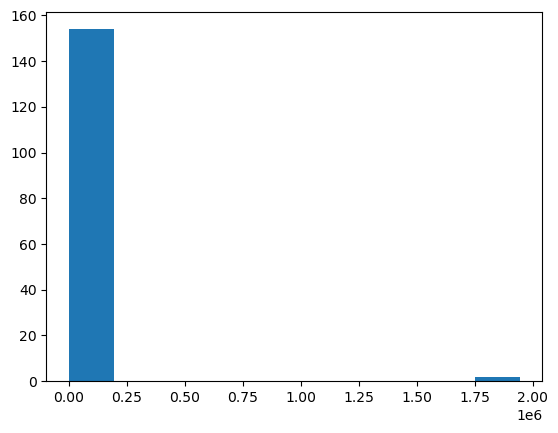

In [44]:
import matplotlib.pyplot as plt

plt.hist(diff.to_numpy().flatten())

In [ ]:
common_cols = ['Angle (kcal/mol)', 'Bond (kcal/mol)', 'Torsion (kcal/mol)']

omm_redux = omm_table.drop(columns=common_cols)
lmp_redux = lmp_table.drop(columns=common_cols)

In [ ]:
omm_table[common_cols] - lmp_table[common_cols]

In [ ]:
omm_redux

In [ ]:
lmp_redux

In [ ]:
compare_cols = ['vdW pairwise (kcal/mol)', 'Potential (kcal/mol)']

(omm_redux[compare_cols] - lmp_redux[compare_cols]) / omm_redux[compare_cols]*100

In [ ]:
omm_redux['1-4 Coulomb (kcal/mol)'] + omm_redux['Electrostatic (kcal/mol)'] - lmp_redux['Coulomb (kcal/mol)']

## Evaluating energies with drivers

In [ ]:
from openff.interchange.drivers.openmm import get_openmm_energies, _get_openmm_energies
from openff.interchange.drivers.lammps import get_lammps_energies, _get_lammps_energies,  _find_lammps_executable
from openff.units.openmm import to_openmm as openff_units_to_openmm

In [ ]:
{
    contrib : openff_units_to_openmm(value).in_units_of(kilocalorie_per_mole)
        for contrib, value in get_openmm_energies(interchange, detailed=True, combine_nonbonded_forces=False).energies.items()
}

In [ ]:
get_lammps_energies(interchange).energies

## Comparing ParmEd energy decomposition to native OpenMM force-group-based decomposition

In [ ]:
import parmed
from openmm.openmm import Force

NULL_ENERGY = 0.0*kilojoule_per_mole

sim = omm_sims['urethane']['urethane_41']
# assign and initialize unique force groups for simulation
for i, force in enumerate(sim.system.getForces()):
    force.setForceGroup(i)
    # print(force.getName(), force.getForceGroup())
sim.context.reinitialize(preserveState=True) # need to reinitialize to get force labelling changes to "stick"

# energies from OpenMM force groups
print('\nOpenMM:')
print('='*30)
omm_energies = {}

## extract total energies for state
overall_state = sim.context.getState(getEnergy=True) # get total potential energy
PE = overall_state.getPotentialEnergy()
omm_energies['Total Potential Energy'] = PE

KE = overall_state.getKineticEnergy()
assert(KE == NULL_ENERGY)

for i, force in enumerate(sim.system.getForces()):
    state = sim.context.getState(getEnergy=True, groups={i})
    force_name = force.getName().removesuffix('Force')
    pe = state.getPotentialEnergy()

    omm_energies[force_name] = pe
    print(f'{force_name} : {pe}')

## converting name to match with ParmEd for comparison
namemap = {
    'Nonbonded' : 'bond',
    'PeriodicTorsion' : 'angle',
    'HarmonicAngle' : 'dihedral',
    'HarmonicBond' : 'urey_bradley',
    'Total Potential Energy' : 'total'
}
compat_omm_energies = {
    namemap[contrib] : energy
        for contrib, energy in omm_energies.items()
}

total = sum(omm_energies.values(), start=NULL_ENERGY) # need "seed" to have Quantity datatype to sum
print(f'{general.GREEK_UPPER["delta"]}E_contrib: ', PE - total)

# ParmEd energy decomposition
print('\nParmEd:')
print('='*30)
parm_energies = {}
parm_struct = parmed.openmm.load_topology(sim.topology, sim.system)
for contrib, energy_val in parmed.openmm.energy_decomposition(parm_struct, sim.context).items():
    parm_energies[contrib] = energy = energy_val*kilocalorie_per_mole # assign proper units
    print(contrib, energy.in_units_of(kilojoule_per_mole))

# Experimenting with SDF files

In [ ]:
benz = Chem.MolFromSmiles('C1ccccC=1')
benz = Chem.AddHs(benz)
benz.SetDoubleProp('stuff', 3.14)
benz

In [ ]:
block2k = Chem.MolToMolFile(benz, 'test_2k.sdf')
block3k = Chem.MolToV3KMolFile(benz, 'test_3k.sdf')

In [ ]:
block2kforce = Chem.MolToMolFile(benz, 'test_2k_force.sdf', forceV3000=True)

In [ ]:
with Chem.SDWriter('test_sdw.sdf') as sdwriter:
    sdwriter.SetForceV3000(True)
    print(sdwriter.GetForceV3000())

    sdwriter.write(benz)

In [ ]:
with Chem.SDMolSupplier('sdf_testing/test_off_rd.sdf', sanitize=False) as suppl:
    mols = [mol for mol in suppl]

targ = mols[0]
targ

In [ ]:
omol = Molecule.from_rdkit(benz)
omol.generate_conformers(n_conformers=1)
omol.visualize(backend='nglview')